# Optimizer Example
Jena Climate ANN example showing the effects of bias on the Adam optimizer.
This is a regression model, using 3-hour data

Gabriella Ferro & Richard Henry, 18-Jul-2024

In [1]:
#Import Libararies
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

Test Libraries

In [2]:
# Check python version
from platform import python_version
print(python_version())
#3.12.3

3.12.3


In [3]:
# Check tensorflow version
tf.__version__
#2.16.1

'2.16.2'

In [4]:
# Check keras version
tf.keras.__version__
#3.4.1

'3.4.1'

# Jena ANN

In [5]:
# Load Data (Already cleaned and decimated)
df3=pd.read_csv('dataset/Jena_climate/cleanJena3.csv')

In [6]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23363 entries, 0 to 23362
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   p (mbar)       23363 non-null  float64
 1   VPact (mbar)   23363 non-null  float64
 2   Tdew (degC)    23363 non-null  float64
 3   T (degC)       23363 non-null  float64
 4   max. wv (m/s)  23363 non-null  float64
 5   NSwind         23363 non-null  float64
 6   EWwind         23363 non-null  float64
 7   year           23363 non-null  int64  
 8   month          23363 non-null  int64  
 9   day            23363 non-null  int64  
 10  hour           23363 non-null  int64  
dtypes: float64(7), int64(4)
memory usage: 2.0 MB


In [7]:
df3.describe()

,p (mbar),VPact (mbar),Tdew (degC),T (degC),max. wv (m/s),NSwind,EWwind,year,month,day,hour
count,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000
mean,989.216246,9.533017,4.954671,9.456338,3.533382,-0.631798,-0.415655,2012.497068,6.517399,15.713222,10.500449
std,8.353071,4.184973,6.730860,8.428081,2.339862,1.983549,1.553730,2.289905,3.448433,8.799298,6.873702
min,942.720000,0.810000,-24.800000,-22.760000,0.000000,-10.783959,-7.148867,2009.000000,1.000000,1.000000,0.000000
25%,984.200000,6.220000,0.240000,3.340000,1.760000,-1.480647,-1.372670,2010.000000,4.000000,8.000000,6.000000
50%,989.590000,8.860000,5.210000,9.440000,2.980000,-0.637933,-0.296919,2012.000000,7.000000,16.000000,12.000000
75%,994.730000,12.360000,10.080000,15.480000,4.730000,0.306138,0.432981,2014.000000,10.000000,23.000000,15.000000
max,1015.170000,28.040000,22.940000,36.460000,18.780000,7.709359,6.966350,2017.000000,12.000000,31.000000,21.000000


In [8]:
# Model / data parameters
blk_len=16*8      #Look back at two weeks of data
stp_len=8         #look forward 24 hours
row_len=len(df3)   #total records (last target location)
col_len=11         #total variables
bat_len=64*8      #batch size of 2 months
epo_len=32         #32 epochs
val_fra=0.2        #use 20% of data for validation
pas_len=blk_len+stp_len  #first target location
cut_len=row_len-pas_len  #last start of predictor location
bias_01=True        #First Dense layer Bias
bias_02=True        #Second Dense layer Bias

In [9]:
%%time
# Reformat
y_train=df3['T (degC)'].iloc[pas_len:].to_numpy()  #pull out all the targets
#start building predictor deck
xAll=df3.to_numpy()
xTrain=np.zeros([cut_len,blk_len,col_len])
for i in range(cut_len):
    for j in range(blk_len):
            xTrain[i][j][:]=xAll[i+j][:]

CPU times: total: 1.97 s
Wall time: 2.3 s


In [10]:
#Normalize Input Data
fixMe=tf.keras.layers.Normalization()
fixMe.adapt(xTrain)

In [11]:
# Build & train model function
def model_build(bias1st,bias2nd):
    #Build it exactly the same every time
    tf.random.set_seed(19)
    model = tf.keras.Sequential(
        [
            tf.keras.Input(shape=(blk_len,col_len)),
            fixMe,
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64,
                                  activation='relu',
                                 use_bias=bias1st),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(32,
                                  activation='relu',
                                 use_bias=bias2nd),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1,
                                  activation='linear',
                                 use_bias=True)
        ]
    )
    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=['mean_absolute_error'])
    myHis=model.fit(xTrain,
                    y_train,
                    batch_size=bat_len,
                    epochs=epo_len,
                    validation_split=val_fra)
    myPre=model.predict(xTrain)
    return myHis,myPre

### First Model, Adam

In [12]:
%%time
h0,p0=model_build(bias_01,bias_02)

Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 73.9326 - mean_absolute_error: 6.6762 - val_loss: 22.4152 - val_mean_absolute_error: 3.7679
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 23.9880 - mean_absolute_error: 3.8328 - val_loss: 16.5476 - val_mean_absolute_error: 3.2225
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 18.6561 - mean_absolute_error: 3.3897 - val_loss: 14.4804 - val_mean_absolute_error: 3.0156
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.3922 - mean_absolute_error: 3.1686 - val_loss: 12.9018 - val_mean_absolute_error: 2.8287
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14.9385 - mean_absolute_error: 3.0218 - val_loss: 12.9656 - val_mean_absolute_error: 2.8462
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14.1825 - mean_absolute_error: 2.9454 - val_loss: 12.3490 - val_mean_absolute_error: 2.7597
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.4310 - mean_absolute_error: 2.8692 - va

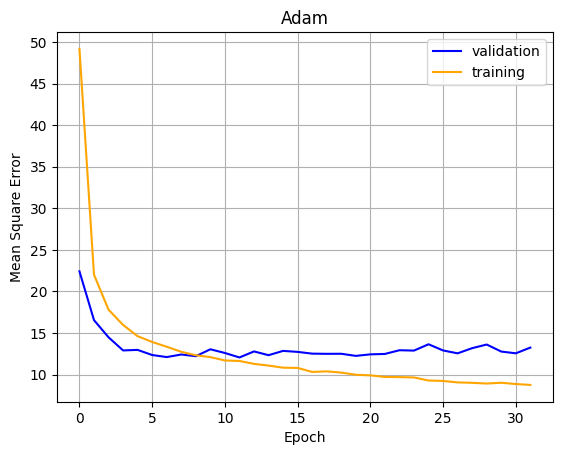

In [13]:
plt.plot(h0.history['val_loss'], color='blue')
plt.plot(h0.history['loss'], color='orange')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['validation','training'])
plt.title('Adam')
plt.grid()
plt.show()

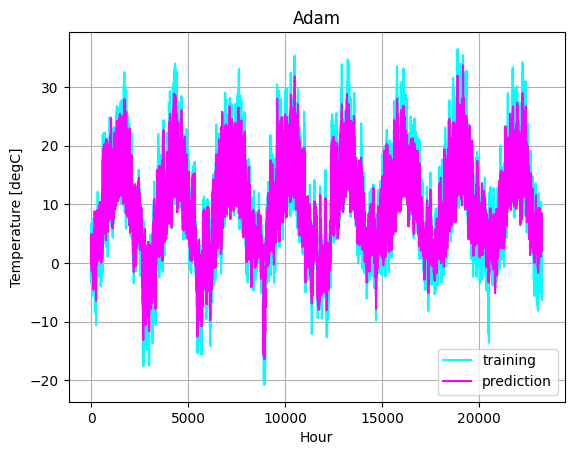

In [14]:
plt.plot(y_train, color='cyan')
plt.plot(p0.flatten(), color='magenta')
plt.ylabel('Temperature [degC]')
plt.xlabel('Hour')
plt.legend(['training','prediction'])
plt.title('Adam')
plt.grid()
plt.show()

In [15]:
#plt.plot(y_train, color='cyan')
#plt.plot(p0.flatten(), color='magenta')
#plt.ylabel('Temperature [degC]')
#plt.xlabel('Hour')
#plt.legend(['training','prediction'])
#plt.title('Adam (Final Year)')
#plt.grid()
#plt.xlim([60588,69348])
#plt.show()

In [16]:
#plt.plot(y_train, color='cyan')
#plt.plot(p0.flatten(), color='magenta')
#plt.ylabel('Temperature [degC]')
#plt.xlabel('Hour')
#plt.legend(['training','prediction'])
#plt.title('Adam (Final Month)')
#plt.grid()
#plt.xlim([68604,69348])
#plt.show()

In [17]:
#plt.plot(y_train, color='cyan')
#plt.plot(p0.flatten(), color='magenta')
#plt.ylabel('Temperature [degC]')
#plt.xlabel('Hour')
#plt.legend(['training','prediction'])
#plt.title('Adam (Final Week)')
#plt.grid()
#plt.xlim([69180,69348])
#plt.show()

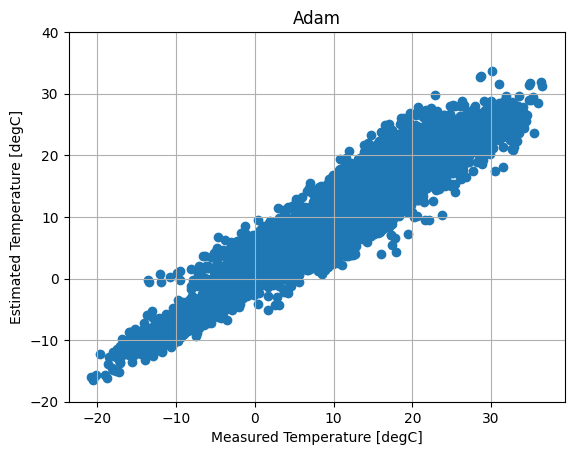

In [18]:
plt.scatter(y_train,p0.flatten())
plt.ylabel('Estimated Temperature [degC]')
plt.xlabel('Measured Temperature [degC]')
plt.title('Adam')
plt.grid()
plt.ylim([-20,40])
plt.show()

#### Commentary
Lorem Ipsum
### Second Model
Blah Blah Blah

In [19]:
%%time
h1,p1=model_build(True,False)

Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 79.3745 - mean_absolute_error: 6.9418 - val_loss: 22.6169 - val_mean_absolute_error: 3.7970
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 24.1471 - mean_absolute_error: 3.8680 - val_loss: 16.1878 - val_mean_absolute_error: 3.1959
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.3021 - mean_absolute_error: 3.4438 - val_loss: 13.9344 - val_mean_absolute_error: 2.9552
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.8054 - mean_absolute_error: 3.2011 - val_loss: 12.8225 - val_mean_absolute_error: 2.8381
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15.4608 - mean_absolute_error: 3.0944 - val_loss: 12.9371 - val_mean_absolute_error: 2.8538
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14.6348 - mean_absolute_error: 2.9898 - val_loss: 12.5645 - val_mean_absolute_error: 2.7928
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13.9263 - mean_absolute_error: 2.9078 - va

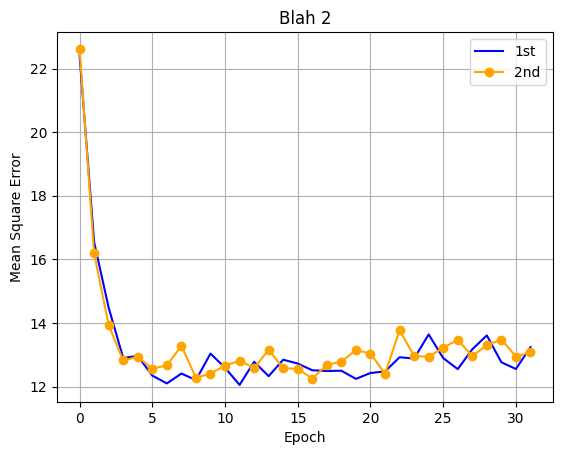

In [20]:
plt.plot(h0.history['val_loss'], color='blue')
plt.plot(h1.history['val_loss'], color='orange',marker='o')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['1st','2nd'])
plt.title('Blah 2')
plt.grid()
plt.show()

#### Commentary
Lorem Impsum
### Third Model
Blah Blah Blah

In [21]:
%%time
h2,p2=model_build(False,True)

Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 71.2871 - mean_absolute_error: 6.5489 - val_loss: 27.3906 - val_mean_absolute_error: 4.3058
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 23.3614 - mean_absolute_error: 3.7892 - val_loss: 17.4004 - val_mean_absolute_error: 3.3319
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.2756 - mean_absolute_error: 3.4354 - val_loss: 14.4096 - val_mean_absolute_error: 3.0136
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.5639 - mean_absolute_error: 3.1837 - val_loss: 13.5499 - val_mean_absolute_error: 2.9099
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14.8879 - mean_absolute_error: 3.0159 - val_loss: 13.0927 - val_mean_absolute_error: 2.8486
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14.1425 - mean_absolute_error: 2.9256 - val_loss: 13.2101 - val_mean_absolute_error: 2.8491
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.2534 - mean_absolute_error: 2.8449 - va

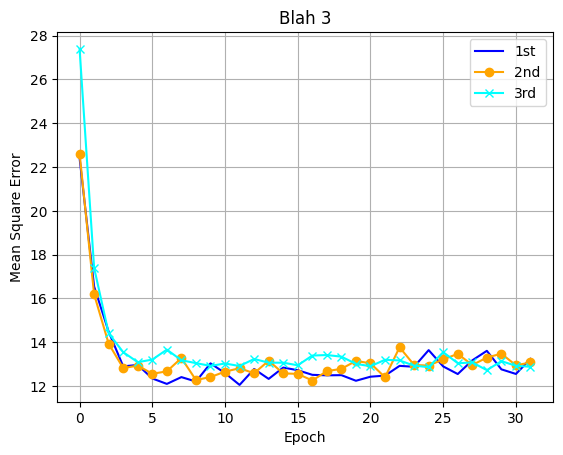

In [22]:
plt.plot(h0.history['val_loss'],color='blue')
plt.plot(h1.history['val_loss'],color='orange',marker='o')
plt.plot(h2.history['val_loss'],color='cyan',marker='x')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['1st','2nd','3rd'])
plt.title('Blah 3')
plt.grid()
plt.show()

#### Commentary
Lorem Impsum
### Fourth Model
Blah Blah Blah

In [23]:
%%time
h3,p3=model_build(False,False)

Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 69.8977 - mean_absolute_error: 6.5510 - val_loss: 22.5827 - val_mean_absolute_error: 3.7628
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 24.7736 - mean_absolute_error: 3.8729 - val_loss: 16.1948 - val_mean_absolute_error: 3.2085
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 19.1417 - mean_absolute_error: 3.4175 - val_loss: 13.7148 - val_mean_absolute_error: 2.9492
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16.8597 - mean_absolute_error: 3.2120 - val_loss: 12.7700 - val_mean_absolute_error: 2.8246
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.1473 - mean_absolute_error: 3.0422 - val_loss: 12.4275 - val_mean_absolute_error: 2.7556
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14.8364 - mean_absolute_error: 2.9951 - val_loss: 12.4481 - val_mean_absolute_error: 2.7490
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14.1732 - mean_absolute_error: 2.9402 - va

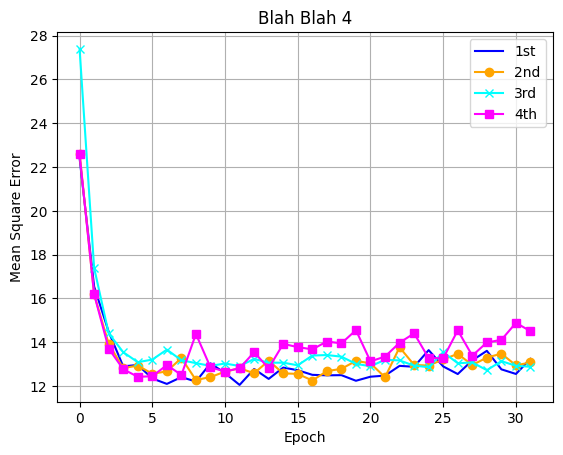

In [24]:
plt.plot(h0.history['val_loss'],color='blue')
plt.plot(h1.history['val_loss'],color='orange',marker='o')
plt.plot(h2.history['val_loss'],color='cyan',marker='x')
plt.plot(h3.history['val_loss'],color='magenta',marker='s')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['1st','2nd','3rd','4th'])
plt.title('Blah Blah 4')
plt.grid()
plt.show()

#### Commentary
Lorem Ipsum
# Conclusions
Blah blah blah